## Setup
### Project setup

In [373]:
if run_init:
    %pip install -U pip
    !if  [ ! -d "deep-learning-project" ] ; then git clone https://github.com/albertsgarde/deep-learning-project.git; fi
    !cd deep-learning-project && git checkout predict-note-instead-of-frequency && git reset --hard && git pull
    !source deep-learning-project/setup.sh deep-learning-project
    import os
    os.chdir("deep-learning-project/deep-learning")
run_init = False
!git pull

Already up to date.


In [374]:
run_init = True

In [375]:
run_init = False

### Imports

In [376]:
import matplotlib.pyplot as plt
import IPython.display as display

import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as nn_func
import torch.optim as optim
from torch.autograd import Variable

import audio_samples_py as aus

import utils

import importlib
importlib.reload(utils)

<module 'utils' from '/app/deep-learning-project/deep-learning/utils.py'>

### Device setup

In [377]:
device, use_cuda = utils.setup_device(use_cuda_if_possible = True)

Running GPU.


## Data
### Parameters

In [378]:
SAMPLE_LENGTH = 256
BATCH_SIZE = 64
SEED = 0 # Generates different data if changed. Useful to ensure that a result isn't a fluke.

parameters = aus.DataParameters(num_samples=SAMPLE_LENGTH).add_sine((0.5,0.75))

### Generation

In [379]:
def label_to_target(label):
    return np.array([label.frequency_map()], dtype = np.float32)

training_parameters, training_loader, validation_parameters, validation_loader = utils.init_synth_data(parameters, label_to_target, SEED, BATCH_SIZE)

## Neural Network

### Model definition.

In [380]:
class ConvMod(nn.Module):
    """Convolutional module containing a list of convolutional layers with ReLU activation and optional batch normalization and dropout."""
    def __init__(self, name, input_size, depth, channels, kernel_sizes, strides, paddings, poolings, batchnorms, dropouts):
        super(ConvMod, self).__init__()

        # Ensure that all parameter lists are long enough.
        assert len(channels) >= depth
        assert len(kernel_sizes) >= depth
        assert len(strides) >= depth
        assert len(paddings) >= depth
        assert len(poolings) >= depth
        assert len(batchnorms) >= depth
        assert len(dropouts) >= depth
        for kernel_size in kernel_sizes:
            assert kernel_size % 2 == 1, "Only odd kernel sizes are supported."
        for dropout in dropouts:
            assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."

        # Calculate the size of the output of each convolutional layer (for each channel).
        conv_size = []
        for i in range(depth):
            conv_dim_reduction = kernel_sizes[i]-1-paddings[i]*2
            assert (input_size - conv_dim_reduction) % (strides[i]*poolings[i]) == 0
            conv_size.append(int((input_size - conv_dim_reduction)/strides[i]/poolings[i]))
            input_size = conv_size[i]
        for i in range(depth):
            print(f"{name} layer {i} output: size={conv_size[i]} channels={channels[i]}")

        # Calculate total size of the output of the convolutional layers.
        self.output_size = conv_size[-1]*channels[-1]
        
        self.module_list = nn.ModuleList()
        in_channels = 1
        for i in range(depth):
            conv = nn.Conv1d(in_channels=in_channels, out_channels=channels[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i])
            in_channels = channels[i]
            pool = nn.MaxPool1d(poolings[i])
            batchnorm = nn.BatchNorm1d(channels[i]) if (batchnorms[i]) else nn.Identity()
            dropout = nn.Dropout(p=dropouts[i])

            self.module_list.append(nn.ModuleList([conv, pool, batchnorm, dropout]))
    
    def forward(self, x):
        for conv, pool, batchnorm, dropout in self.module_list:
            x = conv(x)
            x = pool(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)
        
        return x
    
    def total_output_size(self):
        """ Returns the size of the output of the convolutional layers. """
        return self.output_size

class LinMod(nn.Module):
    def __init__(self, name, in_features, depth, features, batchnorms, dropouts):
        super(LinMod, self).__init__()

        # Ensure that all parameter lists are long enough.
        assert in_features > 0
        assert depth > 0
        assert len(features) >= depth
        assert len(batchnorms) >= depth
        assert len(dropouts) >= depth
        for dropout in dropouts:
            assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."
        for i in range(depth):
            print(f"{name} layer {i} output: size={features[i]}")

        self.module_list = nn.ModuleList()
        for i in range(depth):
            lin = nn.Linear(in_features=in_features, out_features=features[i])
            in_features = features[i]
            batchnorm = nn.BatchNorm1d(features[i]) if (batchnorms[i]) else nn.Identity()
            dropout = nn.Dropout(p=dropouts[i])

            self.module_list.append(nn.ModuleList([lin, batchnorm, dropout]))
        
        self.out_features = in_features

    def forward(self, x):
        for lin, batchnorm, dropout in self.module_list:
            x = lin(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)
            
        return x

    def total_output_size(self):
        return self.out_features


class Net(nn.Module):
    def __init__(self, signal_mod, fft_mod, lin_mod):
        super(Net, self).__init__()
        
        self.signal_mod = signal_mod

        self.fft_mod = fft_mod
        
        self.lin = lin_mod

        self.lin_out = nn.Linear(in_features=self.lin.total_output_size(), out_features=1)
        
        
    def forward(self, signal, fft):
        features = []
        if self.signal_mod:
            signal_features = signal.unsqueeze(1)
            signal_features = self.signal_mod(signal_features).flatten(1)
            features.append(signal_features)
        
        if self.fft_mod:
            fft_features = fft.unsqueeze(1) 
            fft_features = self.fft_mod(fft_features).flatten(1)
            features.append(fft_features)

        features = torch.cat(features, dim=1)

        final_features = self.lin(features)
            
        return self.lin_out(final_features)

### Parameters

In [381]:
signal_conv_depth = 2
signal_kernel_sizes = [7, 7, 5, 5]
signal_conv = ConvMod(
    "signal_conv",
    input_size = SAMPLE_LENGTH,
    depth = signal_conv_depth,
    channels = [8, 8, 8, 8], 
    kernel_sizes = signal_kernel_sizes, 
    strides = [1 for _ in range(signal_conv_depth)], 
    paddings = [int((kernel_size - 1)/2) for kernel_size in signal_kernel_sizes], 
    poolings = [2,2,2,2], 
    batchnorms = [False for _ in range(signal_conv_depth)], 
    dropouts = [0.0 for _ in range(signal_conv_depth)])
#signal_conv = None

fft_conv_depth = 2
fft_kernel_sizes = [7, 7, 5, 5]
fft_conv = ConvMod(
    "fft_conv",
    input_size = SAMPLE_LENGTH,
    depth = fft_conv_depth,
    channels = [8, 8, 8, 8], 
    kernel_sizes = fft_kernel_sizes, 
    strides = [1 for _ in range(fft_conv_depth)], 
    paddings = [int((kernel_size - 1)/2) for kernel_size in fft_kernel_sizes], 
    poolings = [2,2,2,2], 
    batchnorms = [False for _ in range(fft_conv_depth)], 
    dropouts = [0.0 for _ in range(fft_conv_depth)])
#fft_conv = None

lin_depth = 2
lin_mod = LinMod(
    "lin",
    in_features=(signal_conv.total_output_size() if signal_conv else 0) + (fft_conv.total_output_size() if fft_conv else 0),
    depth = lin_depth,
    features = [256, 128],
    batchnorms = [False for _ in range(lin_depth)],
    dropouts = [0.0 for _ in range(lin_depth)]
)

signal_conv layer 0 output: size=128 channels=8
signal_conv layer 1 output: size=64 channels=8
fft_conv layer 0 output: size=128 channels=8
fft_conv layer 1 output: size=64 channels=8
lin layer 0 output: size=256
lin layer 1 output: size=128


### Network

In [382]:
assert signal_conv or fft_conv, "Either signal or fft must be used."

net = Net(signal_conv, fft_conv, lin_mod)
if use_cuda:
    net.cuda()

## Training

### Plotting

In [383]:
def cent_err(output, target):
    output = training_parameters.map_to_frequency(output.item())
    target = training_parameters.map_to_frequency(target.item())
    return abs(aus.cent_diff(output, target))

def note_diff(note1, note2):
    return min(abs(note1-note2), 12 - abs(note1-note2))

def note_err(output, target):
    output_note = round(training_parameters.map_to_note_number(output.item())) % 12
    target_note = round(training_parameters.map_to_note_number(target.item())) % 12
    return note_diff(output_note, target_note)

eval_funcs = [cent_err, note_err]

manual_test_funcs = {
    "Target frequency": lambda output, target, label: target.item(),
    "Output frequency": lambda output, target, label: output.item(),
    "Cent diff": lambda output, target, label: cent_err(output, target),
    "Note diff": lambda output, target, label: note_err(output, target),
}

In [384]:
def plot_history(error_tracker: utils.ErrorTracker, total_batches: int):
    train_iter, train_log_losses, [train_cent_errors, train_note_errors] = error_tracker.train_data()
    val_iter, val_log_losses, [val_cent_errors, val_note_errors] = error_tracker.validation_data()
    
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_iter, train_log_losses, label="Training Loss")
    plt.plot(val_iter, val_log_losses, label="Validation Loss")
    plt.xlim(0, total_batches+1)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_iter, train_cent_errors, label="Training Cent Diff")
    plt.plot(val_iter, val_cent_errors, label="Validation Cent Diff")
    plt.axhline(y=5, color='r', linestyle='-')
    plt.ylim(0, 500)
    plt.xlim(0, total_batches+1)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(train_iter, train_note_errors, label="Training Note Diff")
    plt.plot(val_iter, val_note_errors, label="Validation Note Diff")
    plt.axhline(y=0.05, color='r', linestyle='-')
    plt.ylim(0, 6)
    plt.xlim(0, total_batches+1)
    plt.legend()

    
    plt.show()

### Setup

In [385]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-5

In [386]:
criterion = nn.MSELoss()  

# weight_decay is equal to L2 regularization
optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) 

1
2


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

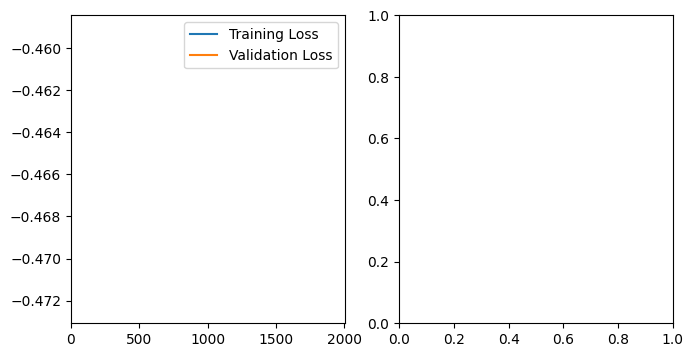

In [387]:
NUM_BATCHES = 2000
EVAL_EVERY = 200
NUM_VALIDATION_BATCHES = 100
LOG_EVERY = EVAL_EVERY


error_tracker = utils.ErrorTracker(criterion, eval_funcs, NUM_VALIDATION_BATCHES)

net.train()
for i, (signal, fft, target, label) in enumerate(itertools.islice(training_loader, NUM_BATCHES+1)):
    if i%EVAL_EVERY == 0:
        error_tracker.update_validation(i, net, validation_loader, criterion)

    signal = utils.to_torch(signal)
    fft = utils.to_torch(fft)
    target = utils.to_torch(target)
    output = net(signal, fft)
    loss = criterion(output, target)

    
    error_tracker.update_training(i, output, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % LOG_EVERY == 0:
        plot_history(error_tracker, NUM_BATCHES)

val_loss, [val_cent_diff, val_note_diff] = utils.test_net(net, validation_loader, criterion, NUM_VALIDATION_BATCHES, eval_funcs)

print(f"Loss={val_loss}, Cent diff={val_cent_diff:.2f}, Note diff={val_note_diff:.2f}")

utils.manual_test(net, validation_loader, 5, manual_test_funcs)